# Get the environment
https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py

Rules:

Pip cards - 2 to 10 points

Face cards - 10 points

Ace - 1 or 11 points

In [49]:
import gym

env = gym.make('Blackjack-v0')

In [50]:
# Actions: stick, hit
print(env.action_space)

Discrete(2)


In [51]:
# State: (player's current sum, dealer's face up card, player has a usable ace?)
# Usable ace: when ace=11 without going bust

print(env.observation_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))


In [52]:
# Randomly choose an action
random_action = env.action_space.sample()

# Perform a step
state, reward, done, info = env.step(random_action)

### Example 

In [53]:
for i_episode in range(3):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(16, 9, False)
End game! Reward:  -1
You lost :(

(18, 10, False)
End game! Reward:  -1
You lost :(

(16, 9, False)
End game! Reward:  -1.0
You lost :(



# Generate episode: deterministic policy
Deterministic policy: The player always sticks if the sum of their cards exceeds 18. 

In [54]:
def generate_episode_from_limit(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        action = 0 if state[0] > 18 else 1
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [55]:
for i in range(3):
    print(generate_episode_from_limit(env))
    
# output:
# state, action, reward 
# (player's sum, dealers face up, player has a usable ace?), action, reward        x (number of states)

[((21, 4, True), 0, 0.0)]
[((14, 10, False), 1, -1)]
[((7, 1, False), 1, 0), ((12, 1, False), 1, 0), ((15, 1, False), 1, 0), ((21, 1, False), 0, 0.0)]


# State-value function
Every-Visit Monte Carlo Method

In [56]:
from collections import defaultdict
import numpy as np
import sys

def mc_prediction_v(env, num_episodes, generate_episode, gamma=1.0):
    
    # initialize empty dictionary of lists
    returns = defaultdict(list)
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        ## TODO: complete the function
        
        episode = generate_episode(env)
        
        states, actions, rewards = zip(*episode)
    
        discounts = np.array([gamma**i for i in range(len(rewards)+1)]) # +1 in order to execute later discounts[:-(i+1)], because [:-0] gives []
        
        
        # Step 1: For each subsequent state i calculate the sum of discounted rewards that come as a consequence (rewards[i:])
        # Step 2: Accumulate (append) rewards of the same visits
        
        for i, state in enumerate(states):
            
            returns[state].append(sum(rewards[i:]* discounts[:-(i+1)]))
    
    # for key, value in dict.items() // dict = {key: value}
    # for state, reward in returns.item()
    
    V = {k: np.mean(v) for k, v in returns.items()}
    return V


Episode 500000/500000.

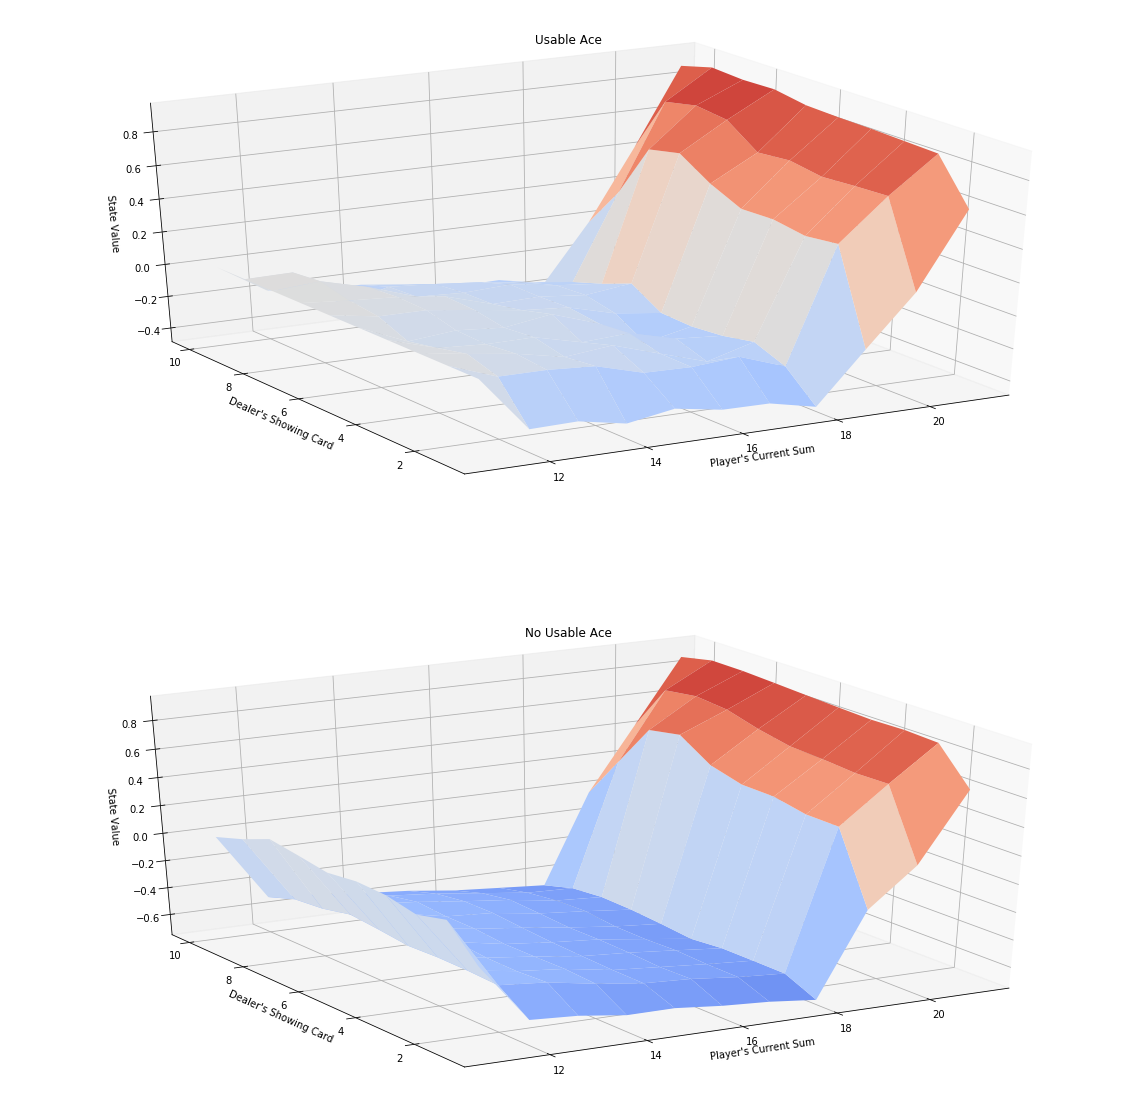

In [57]:
from plot_utils import plot_blackjack_values

V = mc_prediction_v(env, 500000, generate_episode_from_limit)

plot_blackjack_values(V)

# Generate episode: Stochastic policy
Stochastic policy: The player 80% of time sticks if the sum of their cards exceeds 18. Otherwise, he hits.

In [58]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

# Action-value function 
Every-Visit Monte Carlo Method

In [96]:
from collections import defaultdict
import numpy as np
import sys

def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    
    # initialize empty dictionaries of lists
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    returns = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        ## TODO: complete the function
        
        episode = generate_episode(env)
        
        states, actions, rewards = zip(*episode)
    
        discounts = np.array([gamma**i for i in range(len(rewards)+1)]) # +1 in order to execute later discounts[:-(i+1)], because [:-0] gives []
        
        # Step 1: For each subsequent state i calculate the sum of discounted rewards that come as a consequence (rewards[i:])
        # Step 2: Accumulate (append) rewards of the same visits
    
        for i, state in enumerate(states):
                returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
                N[state][actions[i]] += 1.0
                Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
  
    return Q

Episode 500000/500000.

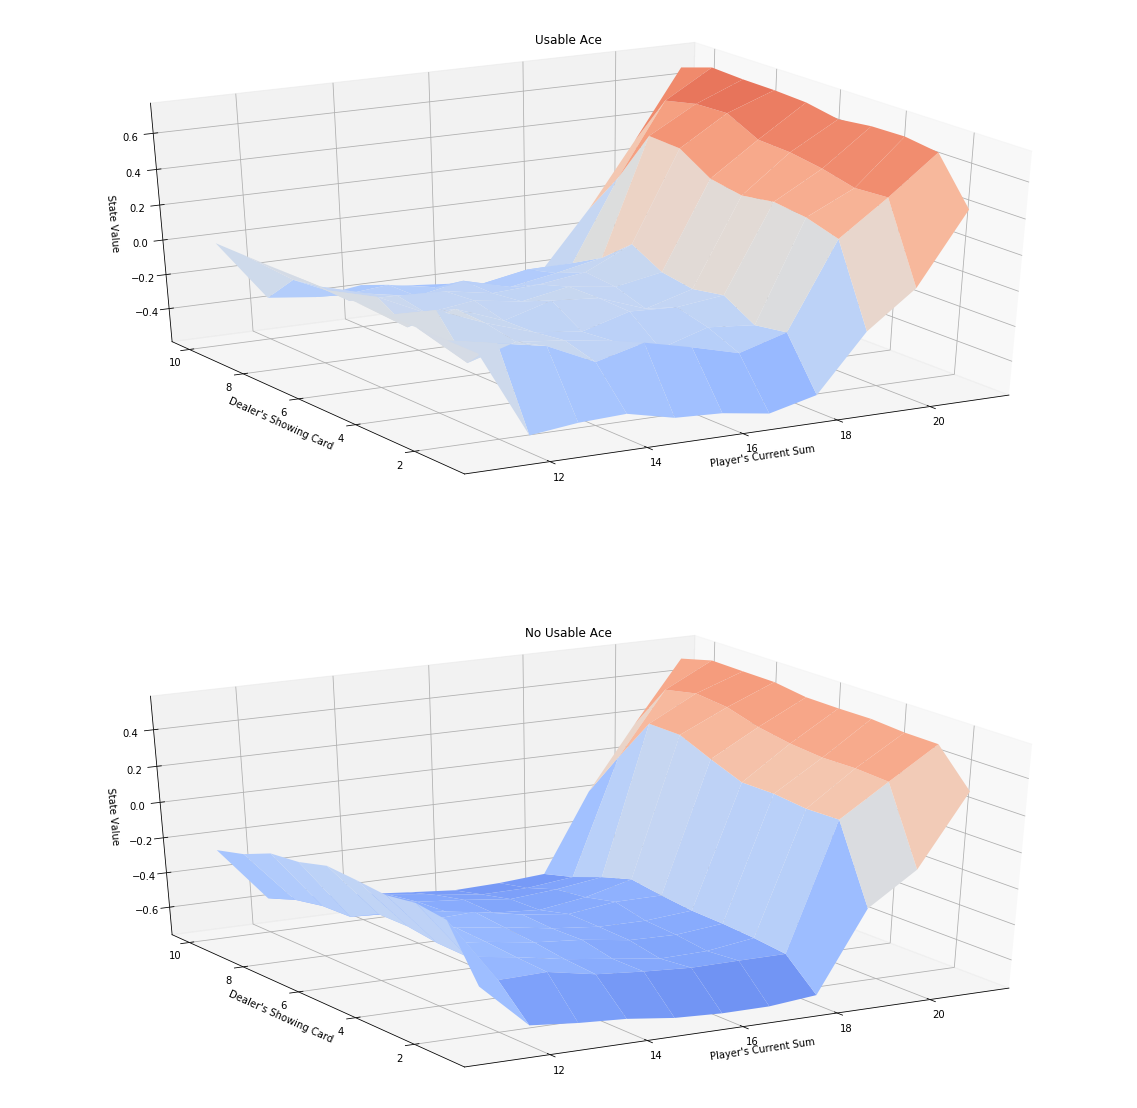

In [97]:
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

# Policy evaluation

## Incremental mean
An algorithm that keeps a running estimate of the mean of rewards gained after each visit. 
The mean is updates after each visit.

In [ ]:
def running_mean(rewards):
    
    mu = 0
    mean_values = []
    
    for k in np.arange(0, len(rewards)):
        mu = mu + (1.0/(k+1))*(rewards[k] - mu)
        mean_values.append(mu)
        
    return mean_values

# Greedy in the Limit with Infinite Exploration (GLIE)

In [99]:
def generate_episode_from_Q(env, Q, epsilon, nA):
    
    episode = []
    state = env.reset()
    
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        
        if done:
            break
            
    return episode

def get_probs(Q_s, epsilon, nA):
    
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    
    return policy_s

def update_Q_GLIE(env, episode, Q, N, gamma):
    
    states, actions, rewards = zip(*episode)
    
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    
    for i, state in enumerate(states):
        
        old_Q = Q[state][actions[i]] 
        old_N = N[state][actions[i]]
        
        # Incremental mean
        Q[state][actions[i]] = old_Q + (sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)/(old_N+1)
        
        N[state][actions[i]] += 1
        
    return Q, N

In [107]:
def mc_control_GLIE(env, num_episodes, gamma=1.0):
    
    # initialize empty dictionaries of arrays
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    N = defaultdict(lambda: np.zeros(nA))
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        epsilon = 1.0/((i_episode/16000)+1)
        
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        
        Q, N = update_Q_GLIE(env, episode, Q, N, gamma)
        
    policy = dict((k, np.argmax(v)) for k, v in Q.items())
    
    return policy, Q

In [108]:
policy_glie, Q_glie = mc_control_GLIE(env, 500000)

Episode 500000/500000.

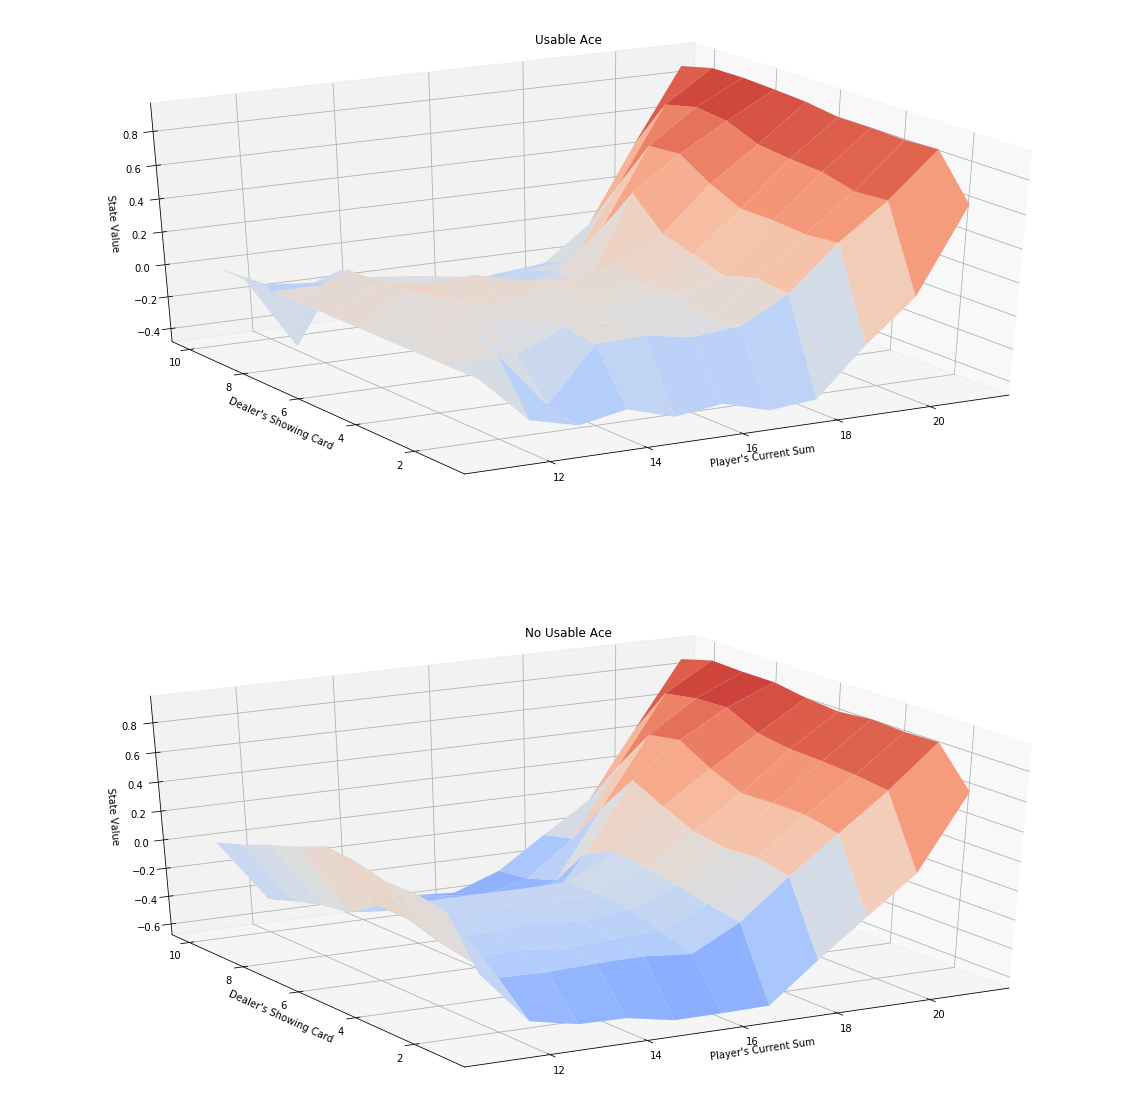

In [109]:
V_glie = dict((k,np.max(v)) for k, v in Q_glie.items())

plot_blackjack_values(V_glie)

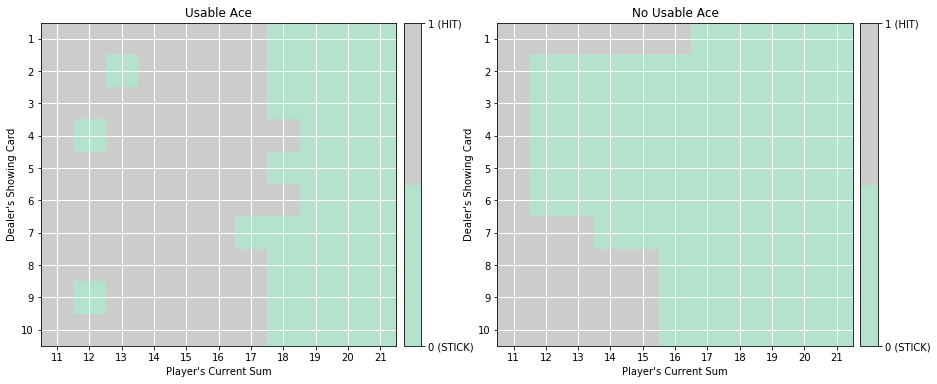

In [110]:
from plot_utils import plot_policy

plot_policy(policy_glie)

# Constant $\alpha$


In [112]:
def update_Q_alpha(env, episode, Q, alpha, gamma):
    
    states, actions, rewards = zip(*episode)
    
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    
    for i, state in enumerate(states):
        
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
        
    return Q

In [113]:
def mc_control_alpha(env, num_episodes, alpha, gamma=1.0):
    
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        epsilon = 1.0/((i_episode/8000)+1)
        
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
    
        Q = update_Q_alpha(env, episode, Q, alpha, gamma)
        
    policy = dict((k, np.argmax(v)) for k, v in Q.items())

    return policy, Q

In [114]:
policy_alpha, Q_alpha = mc_control_alpha(env, 500000, 0.02)

Episode 500000/500000.

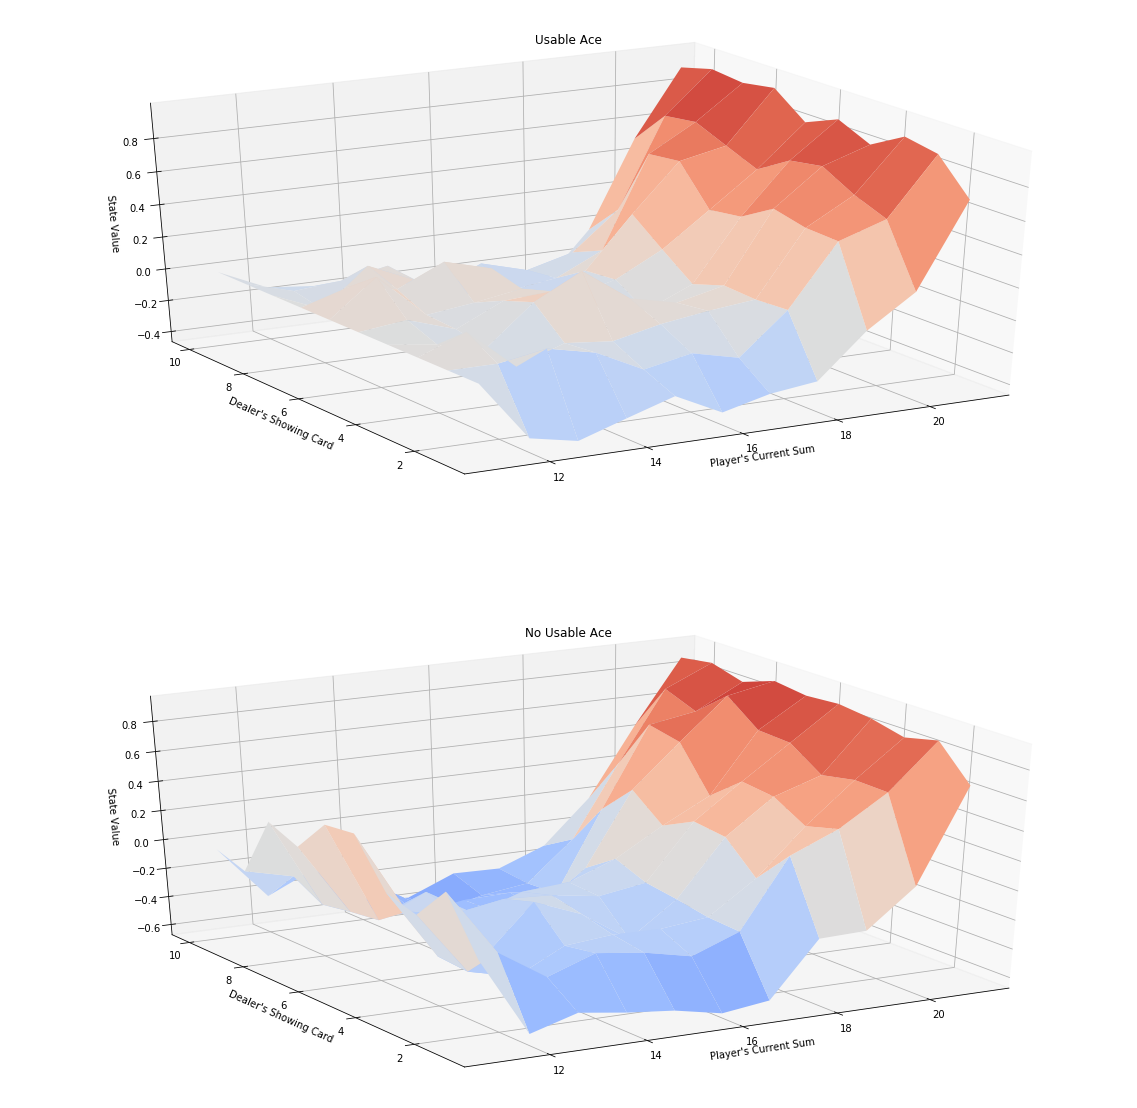

In [115]:
V_alpha = dict((k,np.max(v)) for k, v in Q_alpha.items())

plot_blackjack_values(V_alpha)